# Unit11_Gradient_Boosting_Trees | 梯度提升樹回歸：催化反應器產率預測

本 Notebook 使用模擬數據建立梯度提升樹回歸模型來預測催化反應器的產率。

## 學習目標
- 理解梯度提升樹的序列學習原理與 Boosting 機制
- 使用 `sklearn.ensemble.GradientBoostingRegressor` 建立模型
- 理解學習率與樹數量的權衡關係
- 應用早停機制避免過擬合
- 分析特徵重要性並繪製部分依賴圖
- 比較梯度提升樹與隨機森林的性能差異

## 案例背景
**問題**：催化反應器產率預測  
**特徵**：溫度 (150-250°C)、壓力 (1-5 bar)、催化劑用量 (0.5-2.0 g)  
**目標**：產率 (Yield, 58-92%)  
**資料規模**：1000 個實驗數據點（訓練集 700 / 測試集 300）

---

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit11_Gradient_Boosting_Trees'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit11'
    DATA_DIR = shortcut_path / 'Part_3' / 'data' / SOURCE_DATA_DIR
    OUTPUT_DIR = shortcut_path / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
    print(f"✓ Colab 路徑設定完成")
  else:
    raise FileNotFoundError("請確認 Google Drive 中有 'Colab Notebooks/CHE-AI-COURSE' 資料夾")
else:
  NOTEBOOK_DIR = Path.cwd()
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'
  print(f"✓ Local 路徑設定完成")

# 建立輸出資料夾
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📁 工作目錄: {NOTEBOOK_DIR}")
print(f"📁 輸出目錄: {OUTPUT_DIR}")
print(f"📁 模型目錄: {MODEL_DIR}")
print(f"📁 圖片目錄: {FIG_DIR}")

# ========================================
# GPU 偵測
# ========================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ 偵測到 {len(gpus)} 個 GPU:")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("\n✗ 未偵測到 GPU，使用 CPU 運算")

✓ 偵測到 Local 環境
✓ Local 路徑設定完成

📁 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11
📁 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Gradient_Boosting_Trees
📁 模型目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Gradient_Boosting_Trees\models
📁 圖片目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Gradient_Boosting_Trees\figs

✓ 偵測到 1 個 GPU:
  - /physical_device:GPU:0


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mpl_toolkits.mplot3d import Axes3D

# sklearn 模型與工具
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay

# 設定隨機種子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ 套件載入完成")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"隨機種子: {RANDOM_STATE}")

✓ 套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3
隨機種子: 42


---
## 2. 資料生成（與 Random Forest 相同數據以便比較）

In [3]:
# 生成模擬催化反應器資料（與 Random Forest 相同策略）
np.random.seed(RANDOM_STATE)

n_samples = 1000

# 特徵：溫度 (150-250°C), 壓力 (1-5 bar), 催化劑用量 (0.5-2.0 g)
temperature = np.random.uniform(150, 250, n_samples)
pressure = np.random.uniform(1.0, 5.0, n_samples)
catalyst = np.random.uniform(0.5, 2.0, n_samples)

# 標準化到 [0, 1]
temp_normalized = (temperature - 150) / 100
pressure_normalized = (pressure - 1.0) / 4.0
catalyst_normalized = (catalyst - 0.5) / 1.5

# === 產率模型（與 Random Forest 相同）===
yield_base = 50.0
temp_effect = 15 * (1 - 3*(temp_normalized - 0.5)**2)
pressure_effect = 12 * np.sqrt(pressure_normalized)
catalyst_effect = 8 * np.log(1 + 2*catalyst_normalized)
interaction_effect = 5 * temp_normalized * pressure_normalized
temp_penalty = np.where(temp_normalized > 0.75, -8 * (temp_normalized - 0.75)**2, 0)
pressure_penalty = np.where(pressure_normalized < 0.25, -6 * (0.25 - pressure_normalized)**2, 0)

yield_value = (yield_base + temp_effect + pressure_effect + 
               catalyst_effect + interaction_effect + 
               temp_penalty + pressure_penalty)

# 添加實驗誤差
noise = np.random.normal(0, 3.0, n_samples)
yield_value += noise

# 軟約束函數
def soft_bound(x, lower=50, upper=95):
    """使用 scaled sigmoid 將數據軟約束到目標區間"""
    x_norm = (x - lower) / (upper - lower)
    x_norm = np.where(x_norm < 0, 0.01 + 0.1*x_norm, x_norm)
    x_norm = np.where(x_norm > 1, 0.99 + 0.01*(x_norm-1), x_norm)
    x_norm = np.clip(x_norm, 0.001, 0.999)
    return lower + (upper - lower) * x_norm

yield_value = soft_bound(yield_value, 50, 95)

# 建立 DataFrame
data = pd.DataFrame({
    'Temperature': temperature,
    'Pressure': pressure,
    'Catalyst': catalyst,
    'Yield': yield_value
})

print("✓ 資料生成完成（與 Random Forest 相同數據）")
print(f"\n資料集大小: {data.shape}")
print(f"\n資料統計：")
print(data.describe())

print(f"\n產率分布詳細檢查：")
print(f"  實際最小值: {data['Yield'].min():.2f}%")
print(f"  實際最大值: {data['Yield'].max():.2f}%")
print(f"  平均值: {data['Yield'].mean():.2f}%")
print(f"  標準差: {data['Yield'].std():.2f}%")
print(f"  中位數: {data['Yield'].median():.2f}%")

✓ 資料生成完成（與 Random Forest 相同數據）

資料集大小: (1000, 4)

資料統計：
       Temperature     Pressure     Catalyst        Yield
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    199.025655     3.028069     1.253609    75.596686
std      29.213736     1.168760     0.436011     6.413503
min     150.463202     1.012873     0.500017    54.765301
25%     173.597327     1.964297     0.892026    71.339591
50%     199.680738     3.074936     1.250921    75.991539
75%     224.431959     4.041860     1.638655    80.110571
max     249.971767     4.997655     1.996731    93.307578

產率分布詳細檢查：
  實際最小值: 54.77%
  實際最大值: 93.31%
  平均值: 75.60%
  標準差: 6.41%
  中位數: 75.99%


---
## 3. 探索性資料分析 (EDA)

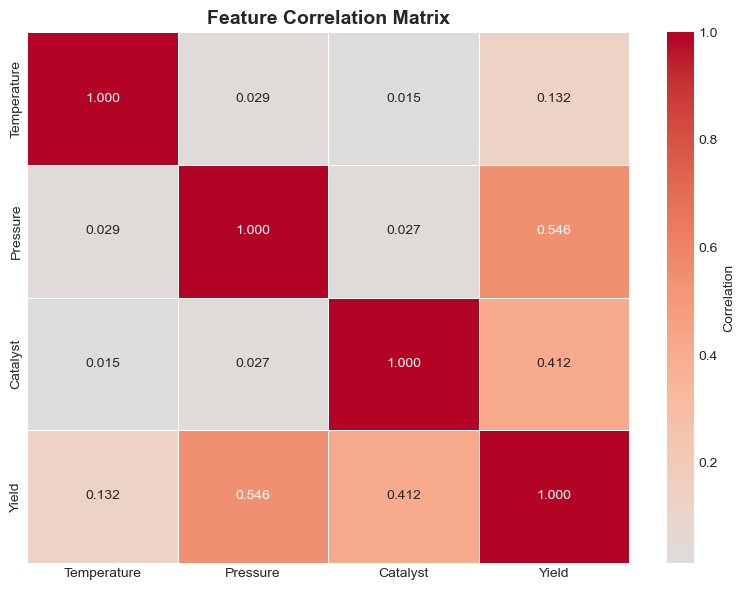

✓ 相關性矩陣圖已儲存


In [4]:
# 特徵相關性矩陣
correlation_matrix = data.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax,
            fmt='.3f', linewidths=0.5, cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '01_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 相關性矩陣圖已儲存")

---
## 4. 資料分割

In [5]:
# 分離特徵和目標
X = data[['Temperature', 'Pressure', 'Catalyst']].values
y = data['Yield'].values
feature_names = ['Temperature', 'Pressure', 'Catalyst']

# 分割訓練集和測試集（70%/30%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print("✓ 資料分割完成")
print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"\n訓練集產率統計：")
print(f"  平均: {y_train.mean():.2f}%")
print(f"  標準差: {y_train.std():.2f}%")
print(f"  範圍: [{y_train.min():.2f}%, {y_train.max():.2f}%]")

✓ 資料分割完成
訓練集大小: (700, 3)
測試集大小: (300, 3)

訓練集產率統計：
  平均: 75.78%
  標準差: 6.24%
  範圍: [54.77%, 93.31%]


---
## 5. 梯度提升樹模型：基礎訓練

In [6]:
# 建立基礎梯度提升樹模型
print("開始訓練梯度提升樹模型（基礎配置）...\n")

start_time = time.time()

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    verbose=0
)

gb_model.fit(X_train, y_train)
elapsed = time.time() - start_time

# 預測
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# 評估
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"✓ 訓練完成，耗時: {elapsed:.2f}s")
print("\n" + "="*60)
print("梯度提升樹模型性能評估（基礎配置）")
print("="*60)
print(f"訓練集 R²: {train_r2:.4f}")
print(f"測試集 R²: {test_r2:.4f}")
print(f"測試集 RMSE: {test_rmse:.2f}%")
print(f"測試集 MAE: {test_mae:.2f}%")
print(f"過擬合差距: {train_r2 - test_r2:.4f}")
print("="*60)

開始訓練梯度提升樹模型（基礎配置）...

✓ 訓練完成，耗時: 0.11s

梯度提升樹模型性能評估（基礎配置）
訓練集 R²: 0.9150
測試集 R²: 0.7558
測試集 RMSE: 3.35%
測試集 MAE: 2.76%
過擬合差距: 0.1591


---
## 6. 學習曲線分析

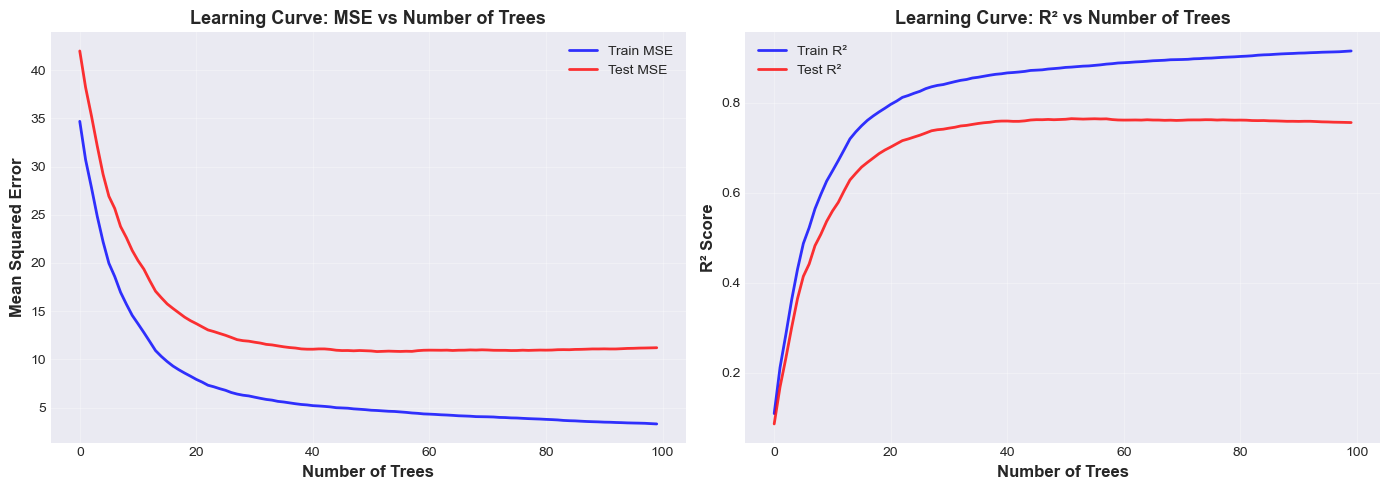

✓ 學習曲線圖已儲存

最佳測試 R² 出現在第 52 棵樹: 0.7645


In [7]:
# 計算訓練過程中的誤差變化
train_scores = []
test_scores = []
train_r2_list = []
test_r2_list = []

for i, y_pred in enumerate(gb_model.staged_predict(X_train)):
    train_scores.append(mean_squared_error(y_train, y_pred))
    train_r2_list.append(r2_score(y_train, y_pred))
    
for i, y_pred in enumerate(gb_model.staged_predict(X_test)):
    test_scores.append(mean_squared_error(y_test, y_pred))
    test_r2_list.append(r2_score(y_test, y_pred))

# 繪製學習曲線
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：MSE 隨樹數量的變化
ax1 = axes[0]
ax1.plot(train_scores, label='Train MSE', alpha=0.8, linewidth=2, color='blue')
ax1.plot(test_scores, label='Test MSE', alpha=0.8, linewidth=2, color='red')
ax1.set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Squared Error', fontsize=12, fontweight='bold')
ax1.set_title('Learning Curve: MSE vs Number of Trees', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 右圖：R² 隨樹數量的變化
ax2 = axes[1]
ax2.plot(train_r2_list, label='Train R²', alpha=0.8, linewidth=2, color='blue')
ax2.plot(test_r2_list, label='Test R²', alpha=0.8, linewidth=2, color='red')
ax2.set_xlabel('Number of Trees', fontsize=12, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Learning Curve: R² vs Number of Trees', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '02_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 學習曲線圖已儲存")
print(f"\n最佳測試 R² 出現在第 {np.argmax(test_r2_list)+1} 棵樹: {max(test_r2_list):.4f}")

---
## 7. 不同學習率的比較

In [8]:
# 測試不同學習率
learning_rates = [0.01, 0.05, 0.1, 0.3]
results_lr = []

print("開始訓練不同學習率的梯度提升樹模型...\n")

for lr in learning_rates:
    start_time = time.time()
    
    gb = GradientBoostingRegressor(
        n_estimators=200,  # 使用更多樹以展示學習率效果
        learning_rate=lr,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    gb.fit(X_train, y_train)
    
    train_score = gb.score(X_train, y_train)
    test_score = gb.score(X_test, y_test)
    elapsed = time.time() - start_time
    
    results_lr.append({
        'learning_rate': lr,
        'train_r2': train_score,
        'test_r2': test_score,
        'time_sec': elapsed
    })
    
    print(f"learning_rate={lr:.2f}: Train R²={train_score:.4f}, "
          f"Test R²={test_score:.4f}, Time={elapsed:.2f}s")

results_lr_df = pd.DataFrame(results_lr)
print("\n✓ 學習率比較完成")

開始訓練不同學習率的梯度提升樹模型...

learning_rate=0.01: Train R²=0.8247, Test R²=0.7232, Time=0.34s
learning_rate=0.05: Train R²=0.9324, Test R²=0.7429, Time=0.34s
learning_rate=0.10: Train R²=0.9652, Test R²=0.7176, Time=0.34s
learning_rate=0.30: Train R²=0.9973, Test R²=0.6688, Time=0.34s

✓ 學習率比較完成


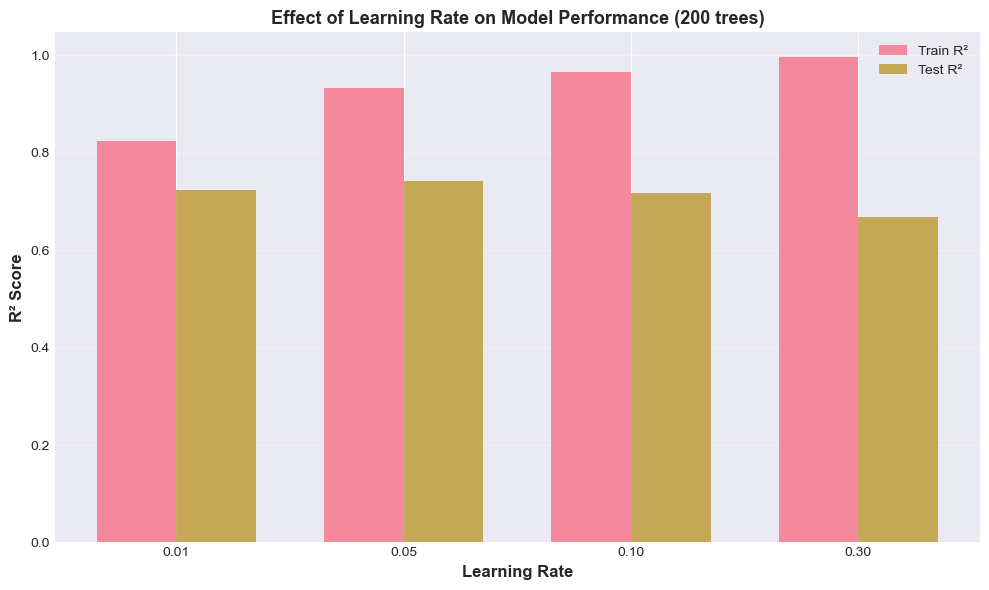

✓ 學習率比較圖已儲存


In [9]:
# 視覺化學習率影響
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(learning_rates))
width = 0.35

ax.bar(x_pos - width/2, results_lr_df['train_r2'], width, label='Train R²', alpha=0.8)
ax.bar(x_pos + width/2, results_lr_df['test_r2'], width, label='Test R²', alpha=0.8)

ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Effect of Learning Rate on Model Performance (200 trees)', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{lr:.2f}' for lr in learning_rates])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / '03_learning_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 學習率比較圖已儲存")

---
## 8. 超參數調整 (GridSearchCV)

In [10]:
# 定義參數網格
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 5, 6],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'subsample': [0.8, 0.9, 1.0]
}

print("開始超參數網格搜尋...")
print(f"參數組合總數: {np.prod([len(v) for v in param_grid.values()])}")

# 建立 GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# 執行網格搜尋
grid_search.fit(X_train, y_train)

# 獲取最佳模型
best_gb = grid_search.best_estimator_

# 最佳參數
print("\n" + "="*60)
print("最佳參數:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\n最佳交叉驗證 R²: {grid_search.best_score_:.4f}")
print("="*60)

開始超參數網格搜尋...
參數組合總數: 729
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

最佳參數:
  learning_rate: 0.05
  max_depth: 4
  min_samples_leaf: 15
  min_samples_split: 10
  n_estimators: 100
  subsample: 0.8

最佳交叉驗證 R²: 0.7305


---
## 9. 最佳模型評估

In [11]:
# 預測
y_pred_train_best = best_gb.predict(X_train)
y_pred_test_best = best_gb.predict(X_test)

# 評估指標
train_r2_best = best_gb.score(X_train, y_train)
test_r2_best = best_gb.score(X_test, y_test)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test_best))
test_mae_best = mean_absolute_error(y_test, y_pred_test_best)

print("="*60)
print("最佳梯度提升樹模型性能評估")
print("="*60)
print(f"訓練集 R²: {train_r2_best:.4f}")
print(f"測試集 R²: {test_r2_best:.4f}")
print(f"測試集 RMSE: {test_rmse_best:.2f}%")
print(f"測試集 MAE: {test_mae_best:.2f}%")
print(f"過擬合差距: {train_r2_best - test_r2_best:.4f}")
print("="*60)

最佳梯度提升樹模型性能評估
訓練集 R²: 0.8411
測試集 R²: 0.7694
測試集 RMSE: 3.25%
測試集 MAE: 2.68%
過擬合差距: 0.0718


---
## 10. 特徵重要性分析


特徵重要性排名 (Gradient Boosting):
1. Temperature: 0.4140 (41.4%)
2. Pressure: 0.3568 (35.7%)
3. Catalyst: 0.2292 (22.9%)


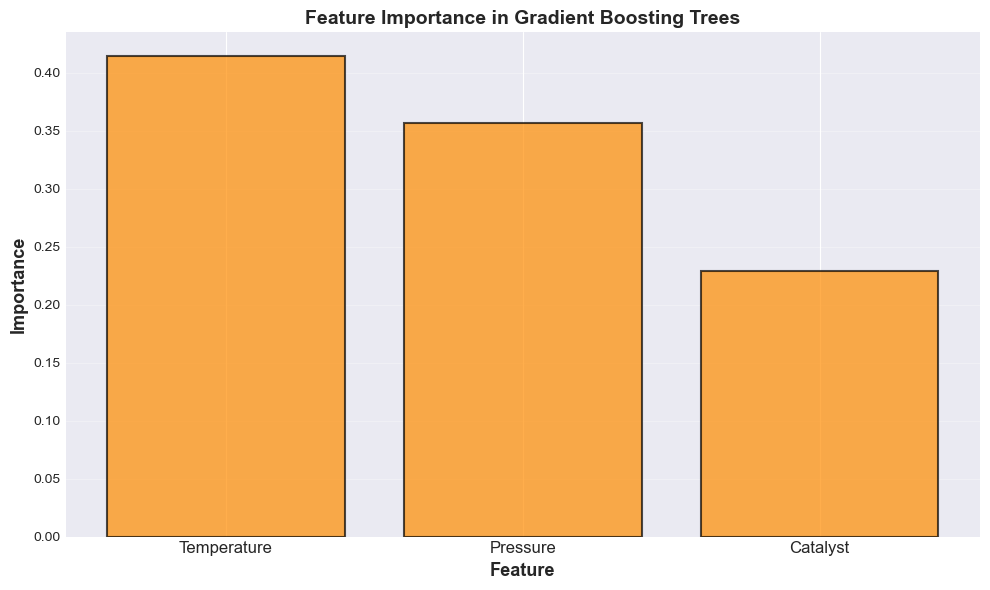


✓ 特徵重要性圖已儲存


In [12]:
# 特徵重要性
importances = best_gb.feature_importances_

# 排序
indices = np.argsort(importances)[::-1]

print("\n特徵重要性排名 (Gradient Boosting):")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f} ({importances[idx]*100:.1f}%)")

# 視覺化
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(importances)), importances[indices], alpha=0.7, color='darkorange', 
       edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([feature_names[i] for i in indices], fontsize=12)
ax.set_xlabel('Feature', fontsize=13, fontweight='bold')
ax.set_ylabel('Importance', fontsize=13, fontweight='bold')
ax.set_title('Feature Importance in Gradient Boosting Trees', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(FIG_DIR / '04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 儲存特徵重要性
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)
feature_importance_df.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)

print("\n✓ 特徵重要性圖已儲存")

---
## 11. 預測結果可視化

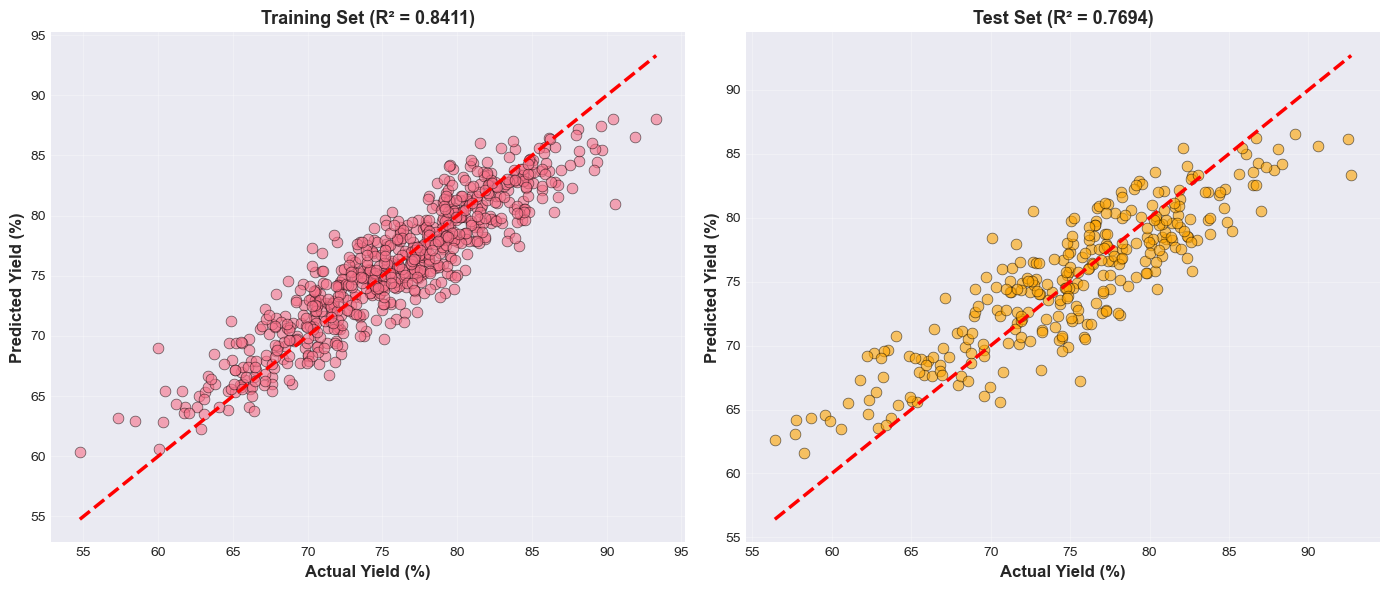

✓ 預測vs實際圖已儲存


In [13]:
# 散點圖：預測 vs 實際
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練集
ax1 = axes[0]
ax1.scatter(y_train, y_pred_train_best, alpha=0.6, edgecolors='k', linewidths=0.5, s=60)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2.5)
ax1.set_xlabel('Actual Yield (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Yield (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Training Set (R² = {train_r2_best:.4f})', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 測試集
ax2 = axes[1]
ax2.scatter(y_test, y_pred_test_best, alpha=0.6, edgecolors='k', linewidths=0.5, s=60, color='orange')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2.5)
ax2.set_xlabel('Actual Yield (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Yield (%)', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Set (R² = {test_r2_best:.4f})', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '05_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 預測vs實際圖已儲存")

---
## 12. 部分依賴圖 (Partial Dependence Plots)

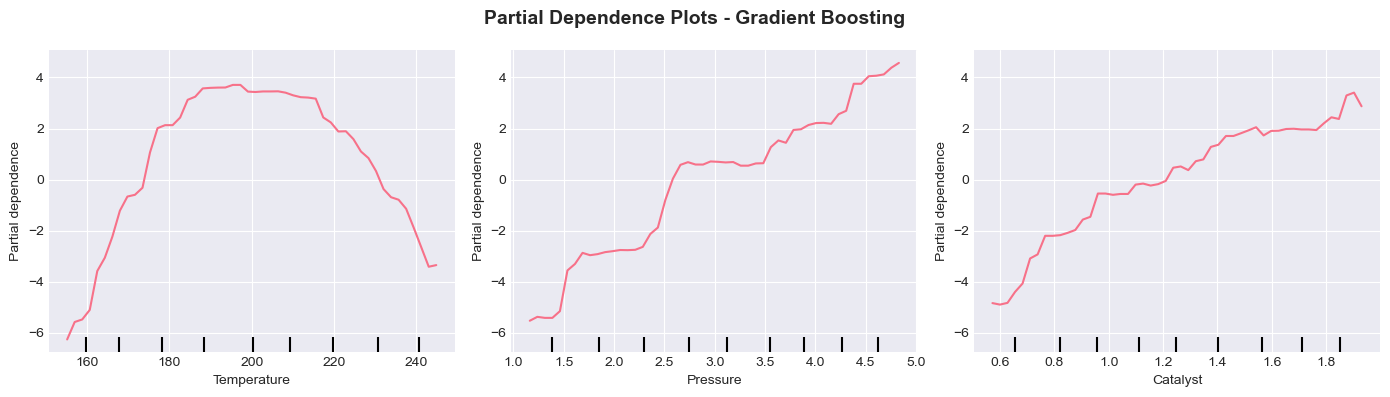

✓ 部分依賴圖已儲存


In [14]:
# 繪製部分依賴圖
fig, ax = plt.subplots(figsize=(14, 4), ncols=3)
PartialDependenceDisplay.from_estimator(
    best_gb, 
    X_train, 
    features=[0, 1, 2],
    feature_names=feature_names,
    ax=ax,
    grid_resolution=50
)
plt.suptitle('Partial Dependence Plots - Gradient Boosting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '06_partial_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 部分依賴圖已儲存")

---
## 13. 最佳操作條件搜尋

最佳操作條件搜尋結果（梯度提升樹）
最佳溫度: 194.90°C
最佳壓力: 4.92 bar
催化劑用量: 1.50 g
預測最大產率: 87.07%


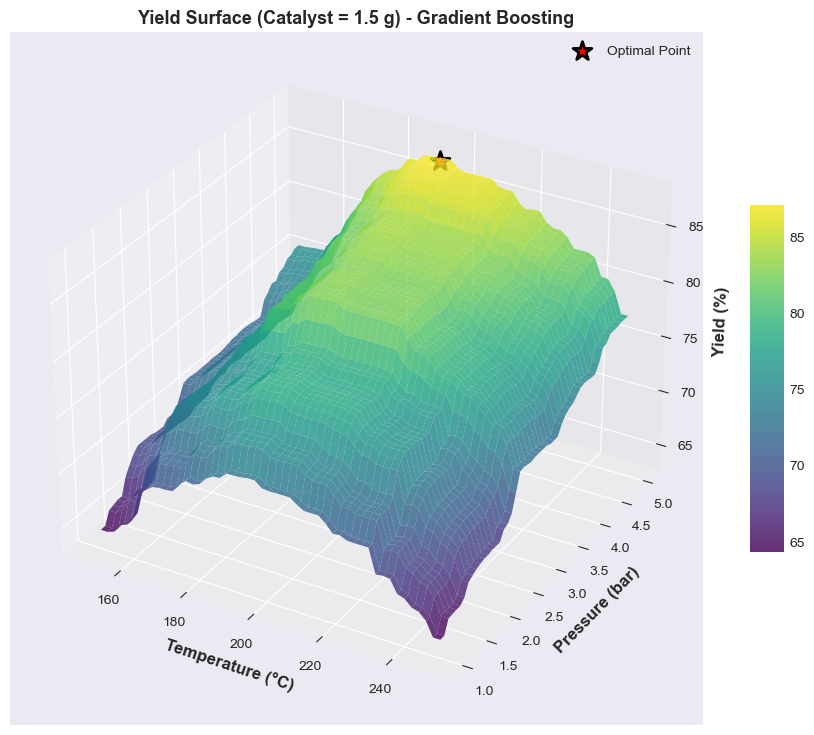


✓ 3D 產率曲面圖已儲存


In [15]:
# 網格搜尋最佳條件
temp_range = np.linspace(150, 250, 50)
press_range = np.linspace(1, 5, 50)
catalyst_best = 1.5  # 固定催化劑用量

# 建立網格
temp_grid, press_grid = np.meshgrid(temp_range, press_range)
X_grid = np.c_[temp_grid.ravel(), press_grid.ravel(), 
               np.full(temp_grid.ravel().shape, catalyst_best)]

# 預測
y_grid = best_gb.predict(X_grid)
y_grid = y_grid.reshape(temp_grid.shape)

# 找最大值
max_idx = np.unravel_index(y_grid.argmax(), y_grid.shape)
optimal_temp = temp_grid[max_idx]
optimal_press = press_grid[max_idx]
optimal_yield = y_grid[max_idx]

print("="*60)
print("最佳操作條件搜尋結果（梯度提升樹）")
print("="*60)
print(f"最佳溫度: {optimal_temp:.2f}°C")
print(f"最佳壓力: {optimal_press:.2f} bar")
print(f"催化劑用量: {catalyst_best:.2f} g")
print(f"預測最大產率: {optimal_yield:.2f}%")
print("="*60)

# 視覺化 3D 曲面
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(temp_grid, press_grid, y_grid, cmap='viridis', alpha=0.8)
ax.scatter(optimal_temp, optimal_press, optimal_yield, color='red', s=200, 
           marker='*', label='Optimal Point', edgecolors='black', linewidths=2)

ax.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Pressure (bar)', fontsize=12, fontweight='bold')
ax.set_zlabel('Yield (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Yield Surface (Catalyst = {catalyst_best:.1f} g) - Gradient Boosting', 
             fontsize=13, fontweight='bold')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.legend(fontsize=10)
plt.savefig(FIG_DIR / '07_yield_surface_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 3D 產率曲面圖已儲存")

---
## 14. 與隨機森林模型比較

In [16]:
# 訓練隨機森林作為對比（使用相同數據）
print("訓練隨機森林模型作為對比...\n")

start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time

# 評估
rf_train_r2 = rf_model.score(X_train, y_train)
rf_test_r2 = rf_model.score(X_test, y_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_model.predict(X_test)))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

print(f"✓ 隨機森林訓練完成，耗時: {rf_time:.2f}s")

# 模型比較表
comparison_data = {
    '模型': ['隨機森林 (300 trees)', '梯度提升樹 (最佳參數)'],
    '訓練 R²': [rf_train_r2, train_r2_best],
    '測試 R²': [rf_test_r2, test_r2_best],
    'RMSE': [rf_test_rmse, test_rmse_best],
    'MAE': [rf_test_mae, test_mae_best],
    '訓練時間 (s)': [rf_time, elapsed]  # 使用基礎模型的訓練時間作為參考
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("模型性能比較：隨機森林 vs 梯度提升樹")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# 儲存比較結果
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print("\n✓ 模型比較結果已儲存")

訓練隨機森林模型作為對比...

✓ 隨機森林訓練完成，耗時: 0.48s

模型性能比較：隨機森林 vs 梯度提升樹
              模型    訓練 R²    測試 R²     RMSE      MAE  訓練時間 (s)
隨機森林 (300 trees) 0.867054 0.721559 3.575491 2.977724  0.479174
    梯度提升樹 (最佳參數) 0.841139 0.769389 3.253933 2.680134  0.342357

✓ 模型比較結果已儲存


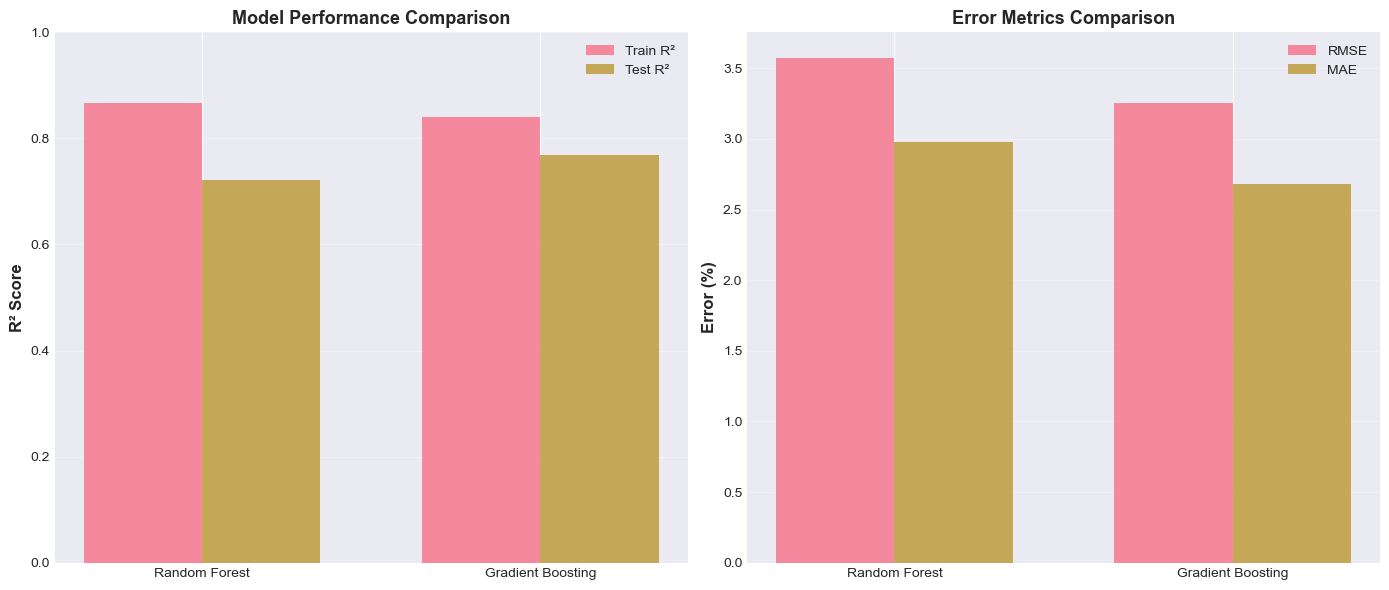

✓ 模型比較圖已儲存


In [17]:
# 視覺化模型比較
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左圖：R² 比較
ax1 = axes[0]
x_pos = np.arange(2)
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['訓練 R²'], width, label='Train R²', alpha=0.8)
ax1.bar(x_pos + width/2, comparison_df['測試 R²'], width, label='Test R²', alpha=0.8)

ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Random Forest', 'Gradient Boosting'], fontsize=10)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1.0])

# 右圖：誤差比較
ax2 = axes[1]
ax2.bar(x_pos - width/2, comparison_df['RMSE'], width, label='RMSE', alpha=0.8)
ax2.bar(x_pos + width/2, comparison_df['MAE'], width, label='MAE', alpha=0.8)

ax2.set_ylabel('Error (%)', fontsize=12, fontweight='bold')
ax2.set_title('Error Metrics Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Random Forest', 'Gradient Boosting'], fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / '08_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 模型比較圖已儲存")

---
## 15. 實驗總結

In [18]:
# 建立綜合總結報告
overfitting_gap = train_r2_best - test_r2_best
if overfitting_gap > 0.2:
    overfitting_status = "嚴重過擬合"
elif overfitting_gap > 0.1:
    overfitting_status = "中度過擬合"
elif overfitting_gap > 0.05:
    overfitting_status = "輕微過擬合"
else:
    overfitting_status = "良好"

# RF 與 GBT 性能差異
r2_improvement = ((test_r2_best - rf_test_r2) / rf_test_r2) * 100
rmse_improvement = ((rf_test_rmse - test_rmse_best) / rf_test_rmse) * 100

summary = {
    '模型類型': '梯度提升樹回歸 (Gradient Boosting Trees)',
    '資料規模': f'{len(data)} 樣本（訓練 {len(X_train)} / 測試 {len(X_test)}）',
    '最佳樹數量': f"{grid_search.best_params_['n_estimators']} 棵",
    '最佳學習率': f"{grid_search.best_params_['learning_rate']}",
    '最佳深度': f"{grid_search.best_params_['max_depth']}",
    '最佳 min_samples_split': f"{grid_search.best_params_['min_samples_split']}",
    '最佳 min_samples_leaf': f"{grid_search.best_params_['min_samples_leaf']}",
    '最佳 subsample': f"{grid_search.best_params_['subsample']}",
    '訓練集 R²': f"{train_r2_best:.4f}",
    '測試集 R²': f"{test_r2_best:.4f}",
    '交叉驗證 R²': f"{grid_search.best_score_:.4f}",
    '過擬合差距 (Train-Test)': f"{overfitting_gap:.4f}",
    '過擬合狀態': overfitting_status,
    '測試集 RMSE': f"{test_rmse_best:.2f}%",
    '測試集 MAE': f"{test_mae_best:.2f}%",
    '最重要特徵': f"{feature_names[indices[0]]} ({importances[indices[0]]:.4f})",
    '最佳操作條件': f"T={optimal_temp:.1f}°C, P={optimal_press:.1f}bar, Cat={catalyst_best:.1f}g",
    '預測最大產率': f"{optimal_yield:.2f}%",
    '隨機森林測試 R²': f"{rf_test_r2:.4f}",
    'R² 提升（vs RF）': f"{r2_improvement:+.2f}%",
    'RMSE 改善（vs RF）': f"{rmse_improvement:+.2f}%"
}

print("\n" + "="*80)
print(" "*20 + "梯度提升樹模型實驗總結")
print("="*80)
for key, value in summary.items():
    print(f"{key:30s}: {value}")
print("="*80)

# 過擬合診斷建議
print("\n【過擬合診斷】")
if overfitting_gap > 0.2:
    print("⚠️  嚴重過擬合警告！")
    print("   建議：1) 降低學習率")
    print("        2) 減少樹的深度")
    print("        3) 增加正則化（min_samples_split, min_samples_leaf）")
elif overfitting_gap > 0.1:
    print("⚠️  中度過擬合")
    print("   建議：適當調整學習率或樹的複雜度")
elif overfitting_gap > 0.05:
    print("✓  輕微過擬合，屬於可接受範圍")
else:
    print("✓  模型泛化能力良好")

print("\n【與隨機森林比較】")
if r2_improvement > 0:
    print(f"✓  梯度提升樹性能優於隨機森林 ({r2_improvement:+.2f}% R² 提升)")
else:
    print(f"⚠️  隨機森林性能略優於梯度提升樹 ({r2_improvement:.2f}% R² 差距)")

# 儲存總結
summary_df = pd.DataFrame([summary])
summary_df.to_csv(OUTPUT_DIR / 'model_summary.csv', index=False)

print("\n✓ 實驗總結已儲存至", OUTPUT_DIR / 'model_summary.csv')


                    梯度提升樹模型實驗總結
模型類型                          : 梯度提升樹回歸 (Gradient Boosting Trees)
資料規模                          : 1000 樣本（訓練 700 / 測試 300）
最佳樹數量                         : 100 棵
最佳學習率                         : 0.05
最佳深度                          : 4
最佳 min_samples_split          : 10
最佳 min_samples_leaf           : 15
最佳 subsample                  : 0.8
訓練集 R²                        : 0.8411
測試集 R²                        : 0.7694
交叉驗證 R²                       : 0.7305
過擬合差距 (Train-Test)            : 0.0718
過擬合狀態                         : 輕微過擬合
測試集 RMSE                      : 3.25%
測試集 MAE                       : 2.68%
最重要特徵                         : Temperature (0.4140)
最佳操作條件                        : T=194.9°C, P=4.9bar, Cat=1.5g
預測最大產率                        : 87.07%
隨機森林測試 R²                     : 0.7216
R² 提升（vs RF）                  : +6.63%
RMSE 改善（vs RF）                : +8.99%

【過擬合診斷】
✓  輕微過擬合，屬於可接受範圍

【與隨機森林比較】
✓  梯度提升樹性能優於隨機森林 (+6.63% R² 提升)

✓ 實驗總結已儲存至 d:\MyGi